In [40]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import seaborn as snsn
import numpy as np
import pandas as pd
import xgboost as xgb
from keras import optimizers
from keras.metrics import mean_squared_error
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.linear_model import Lasso,Ridge
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,scale,normalize,StandardScaler,Imputer
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras import backend as K

# calculate the Variance Inflation Factor to determine collinearity in the Macro data set

In [56]:
df_test = pd.read_csv('data/test.csv',parse_dates=['timestamp'])
df_macro = pd.read_csv('data/macro.csv',parse_dates=['timestamp'])

df_macro = df_macro[df_macro['timestamp']<=max(df_test.timestamp)]


df_macro.drop(['timestamp'],axis =1,inplace=True)
macro_nominal = df_macro.select_dtypes(include=['object'])
macro_numeric = df_macro.select_dtypes(exclude=['object'])
new_macro_nominal = pd.DataFrame()
#fill na values 
def most_common(lst):
    return max(set(lst), key=lst.count)
#for nominal_key in macro_nominal.keys():
#    common_forna = most_common(list(df_macro[nominal_key].dropna()))
#    macro_nominal[nominal_key].fillna(common_forna,inplace=True)
#for numeric_key in macro_numeric.keys():
    #median_forna = df_macro[numeric_key].median()
    #macro_numeric[numeric_key].fillna(0,inplace=True)
imputer = Imputer(strategy='median')
macro_numeric = pd.DataFrame(imputer.fit_transform(macro_numeric),columns=macro_numeric.columns)
for nominal_key in macro_nominal.keys():
    new_macro_nominal[nominal_key] = pd.factorize(macro_nominal[nominal_key])[0]
#new_macro_nominal = pd.get_dummies(macro_nominal)
df_macro = pd.concat([new_macro_nominal,macro_numeric],axis=1)

In [57]:
new_macro = df_macro.copy()
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(df_macro.values,index) for index in range(df_macro.shape[1])]
vif['feature'] = df_macro.columns
print(vif)
vif[vif.vif==max(vif.vif)]
while(max(vif.vif)>10):
    #new_macro = new_macro[new_macro.keys()-[vif[vif.vif==max(vif.vif)].feature.iloc[0]]]
    new_macro = new_macro[new_macro.keys().difference([vif[vif.vif==max(vif.vif)].feature.iloc[0]])]
    print(vif[vif.vif==max(vif.vif)].feature.iloc[0]+' '+str(max(vif.vif)))
    vif = pd.DataFrame()
    vif['vif'] = [variance_inflation_factor(new_macro.values,index) for index in range(new_macro.shape[1])]
    vif['feature'] = new_macro.columns
vif   

           vif                                     feature
0          inf                     child_on_acc_pre_school
1          inf                      modern_education_share
2          inf                   old_education_build_share
3   127.038991                                   oil_urals
4    12.861786                                   gdp_quart
5    36.302352                            gdp_quart_growth
6   406.323465                                         cpi
7   126.247464                                         ppi
8          inf                                gdp_deflator
9    14.154521                               balance_trade
10    8.065423                        balance_trade_growth
11  534.502404                                      usdrub
12  226.063623                                      eurrub
13  110.293852                                       brent
14   10.169848                          net_capital_export
15         inf                                  gdp_annu

,vif,feature
0,2.035668,balance_trade_growth
1,1.724629,deposits_growth
2,4.740973,gdp_quart_growth
3,5.323256,mortgage_growth
4,2.563096,mortgage_value
5,1.615984,net_capital_export
6,4.294144,unemployment


# Feature engineering

In [273]:
df_train = pd.read_csv('data/train.csv',parse_dates=['timestamp'])
num_train = len(df_train)

df_test = pd.read_csv('data/test.csv',parse_dates=['timestamp'])

macro_cols = vif.feature.values
#macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
#"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
#"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

df_macro = pd.read_csv('data/macro.csv',usecols=list(macro_cols)+['timestamp'])

Ylog_train = np.log1p(df_train.price_doc)
df_train.drop(['id','price_doc'],axis = 1,inplace = True)

test_id = df_test.id
df_test.drop(['id'],axis=1,inplace=True)

df_all = pd.concat([df_train,df_test])
df_all = pd.merge(df_all,df_macro,how='left',on='timestamp')

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)


df_all.drop(['timestamp'],axis=1,inplace=True)

print('The shape of df_train data:'+str(df_train.shape))
print('The shape of df_test data:'+str(df_test.shape))
print('The shape of df_all data:'+str(df_all.shape))

The shape of df_train data:(30471, 290)
The shape of df_test data:(7662, 290)
The shape of df_all data:(38133, 302)


In [274]:
# cleaning the life_sq and full_sq
df_all.loc[df_all.life_sq==1,'life_sq'] = np.nan
df_all.loc[df_all.life_sq==0,'life_sq'] = np.nan
df_all.loc[df_all.life_sq>2000,'life_sq'] = np.nan
df_all.loc[df_all.full_sq==1,'full_sq'] = np.nan
df_all.loc[df_all.full_sq==0,'full_sq'] = np.nan
df_all.loc[df_all.full_sq>2000,'full_sq'] = np.nan
# cleaning the data where life_sq>full_sq
df_all.loc[df_all.life_sq>df_all.full_sq,['life_sq','full_sq']]=np.nan

In [275]:
numeric_list = []
nominal_list = []
numeric_list = df_all.select_dtypes(exclude=['object']).columns
nominal_list = df_all.select_dtypes(include=['object']).columns
df_numeric = df_all[numeric_list]
df_nominal = df_all[nominal_list]

In [276]:
#fill na values 
def most_common(lst):
    return max(set(lst), key=lst.count)
#for nominal_key in nominal_list:
#    common_forna = most_common(list(df_all[nominal_key].dropna()))
#    df_nominal[nominal_key].fillna(common_forna,inplace=True)
#for numeric_key in numeric_list:
#    median_forna = df_all[numeric_key].median()
#    df_numeric[numeric_key].fillna(median_forna,inplace=True)

In [277]:
new_df_nominal = pd.DataFrame()
labelencoder = LabelEncoder()
#for nominal_key in df_nominal.keys():
#    #new_df_nominal[nominal_key] = labelencoder.fit_transform(df_nominal[nominal_key])
#    new_df_nominal[nominal_key] = pd.factorize(df_nominal[nominal_key])[0]
#onehotencoder = OneHotEncoder(sparse=False)
#onehotencoder.fit(new_df_nominal)
#new_df_nominal = onehotencoder.transform(new_df_nominal)
new_df_nominal = pd.get_dummies(df_nominal)
df_all = pd.concat([new_df_nominal,df_numeric],axis=1)
df_train = df_all[:num_train]
df_test = df_all[num_train:]


#scaler = StandardScaler()
#df_train_norm = pd.DataFrame(scaler.fit_transform(df_train),columns=df_train.columns)

#df_test_norm = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

print('The shape of df_train:' + str(df_train.shape))
print('The shape of df_test:'+str(df_test.shape))

The shape of df_train:(30471, 464)
The shape of df_test:(7662, 464)


In [278]:
# Training validation split
X_train,X_val,Y_train,Y_val = train_test_split(df_train,Ylog_train,test_size=0.05)
print('The shape of X_train data:' + str(X_train.shape))
print('The shape of X_val data:'+str(X_val.shape))
global X_DIM 
X_DIM = X_train.shape[1]

The shape of X_train data:(28947, 464)
The shape of X_val data:(1524, 464)


# Training the model (XGB)

In [279]:
def rmsl(y,ypred):
    'function that calculate the Root Mean Squared Logarithmic Error'
    return np.sqrt(np.mean(np.square(y-ypred)))
def save_result(index,price_doc,filename):
    'function that store the result y_pred into file with name filename'
    result_df = pd.DataFrame({'id':index,'price_doc':price_doc})
    result_df.to_csv(filename,header=True,index=False)

In [280]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'lambda':1.1,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}
dtrain = xgb.DMatrix(X_train, Y_train)
dtrain_total = xgb.DMatrix(df_train,Ylog_train)
dval = xgb.DMatrix(X_val,Y_val)
dtest = xgb.DMatrix(df_test)

[0]	train-rmse:14.8204+0.000883068	test-rmse:14.8204+0.00178301
[20]	train-rmse:9.90289+0.000670607	test-rmse:9.90291+0.00209725
[40]	train-rmse:6.62272+0.000489245	test-rmse:6.62286+0.00241741
[60]	train-rmse:4.4373+0.000495765	test-rmse:4.43776+0.00245367
[80]	train-rmse:2.9843+0.000444204	test-rmse:2.98582+0.00240957
[100]	train-rmse:2.023+0.00052246	test-rmse:2.02603+0.00238997
[120]	train-rmse:1.39334+0.000706292	test-rmse:1.39897+0.0023763
[140]	train-rmse:0.989169+0.000931836	test-rmse:0.99876+0.00247178
[160]	train-rmse:0.739133+0.00124079	test-rmse:0.753652+0.00276776
[180]	train-rmse:0.592602+0.00152099	test-rmse:0.612696+0.0031098
[200]	train-rmse:0.511924+0.00191381	test-rmse:0.537199+0.00343529
[220]	train-rmse:0.469333+0.00190744	test-rmse:0.499258+0.00385235
[240]	train-rmse:0.447005+0.00203103	test-rmse:0.480727+0.00399844
[260]	train-rmse:0.435199+0.00209307	test-rmse:0.471976+0.00392785
[280]	train-rmse:0.427958+0.00212964	test-rmse:0.467568+0.00396474
[300]	train-rms

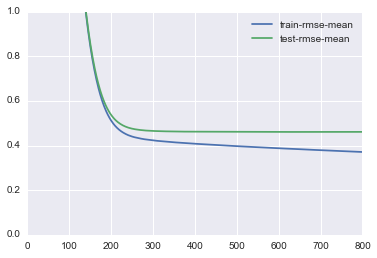

In [281]:
#model = xgb.train(dict(xgb_params), dtrain, num_boost_round=1000,
#                  evals=[(dtrain,'train'),(dval, 'val')],verbose_eval=20)
model = xgb.cv(dict(xgb_params), dtrain, num_boost_round=800,nfold=3,
                  verbose_eval=20)
model[['train-rmse-mean', 'test-rmse-mean']].plot(ylim=(0,1))

In [ ]:
model = xgb.cv(dict(xgb_params), dtrain, num_boost_round=800,nfold=3,
                  verbose_eval=20)
model[['train-rmse-mean', 'test-rmse-mean']].plot(ylim=(0,1))

In [127]:
model = xgb.train(dict(xgb_params), dtrain_total, num_boost_round=800,
                  evals=[(dtrain_total,'train_total')],verbose_eval=50)

[0]	train_total-rmse:14.8195
[50]	train_total-rmse:5.41862
[100]	train_total-rmse:2.02307
[150]	train_total-rmse:0.851439
[200]	train_total-rmse:0.520102
[250]	train_total-rmse:0.45185
[300]	train_total-rmse:0.436589
[350]	train_total-rmse:0.429895
[400]	train_total-rmse:0.424547
[450]	train_total-rmse:0.420232
[500]	train_total-rmse:0.416235
[550]	train_total-rmse:0.412608
[600]	train_total-rmse:0.409186
[650]	train_total-rmse:0.40574
[700]	train_total-rmse:0.402296
[750]	train_total-rmse:0.398903


In [128]:
f_score = model.get_fscore()
high_score = dict()
for feature in f_score:
    if(f_score[feature]>100):
        high_score[feature] = f_score[feature]

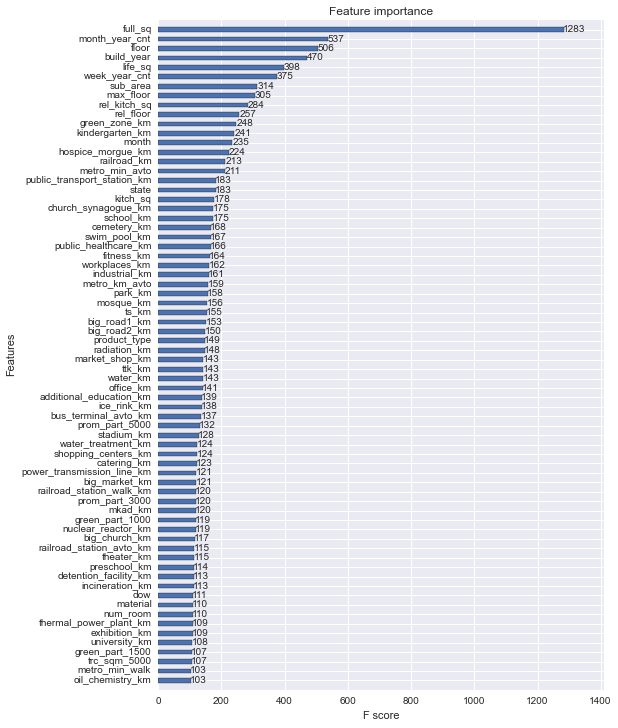

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(8, 12))
xgb.plot_importance(high_score, height=0.5, ax=ax)

In [130]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred)-1
save_result(test_id,y_pred,'output/xgb.csv')

# Training the model (NN)

In [274]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def rms(y,ypred):
    'function that calculate the Root Mean Squared '
    return np.sqrt(np.mean(np.square(y-ypred)))
### define baseline model

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def baseline_model(X_dim_input=X_DIM):
    #create model
    model = Sequential()
    #add layers
    model.add(Dense(2000,input_dim=X_dim_input,init='normal',activation='relu',
                    W_regularizer=regularizers.l2(0.1),b_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1000,input_dim=X_dim_input,init='normal',activation='relu',
                    W_regularizer=regularizers.l2(0.01),b_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(600,input_dim=X_dim_input,init='normal',activation='relu',
                    W_regularizer=regularizers.l2(0.01),b_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    #model.add(Dense(300,init='normal',activation = 'relu'))
    #model.add(BatchNormalization())
    model.add(Dense(1,init = 'normal')
    #compile model
    adam = optimizers.adam(lr=0.00005)
    #sgd = optimizers.sgd(lr=0.0002, decay=1e-6, momentum=0.9, nesterov=False)
    model.compile(loss=root_mean_squared_error, optimizer=adam)
    return model


# fix random seed for reproducibility
seed = 8
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = []
#estimator.append(('standardize',StandardScaler()))
estimator.append(('mlp',KerasRegressor(build_fn=baseline_model, nb_epoch=4, batch_size=32, verbose=1)))
pipeline = Pipeline(estimator)

#figure out rough parameters before CV
nn_model = baseline_model()
nn_model.fit(X_train.values,Y_train.values,nb_epoch=20,
             batch_size=128,validation_data = (X_val.values,Y_val) ,verbose=1)

#Cross validation
#kfold = KFold(n=28947,n_folds=3, random_state=seed)
#results = cross_val_score(pipeline, df_train, Ylog_train, cv=kfold,n_jobs=1)

Train on 28947 samples, validate on 1524 samples
Epoch 1/20
28947/28947 [==============================] - 79s - loss: 262.6842 - val_loss: 15.1469
Epoch 2/20
28947/28947 [==============================] - 75s - loss: 188.2956 - val_loss: 14.3599
Epoch 3/20
28947/28947 [==============================] - 75s - loss: 136.0844 - val_loss: 13.0657
Epoch 4/20
28947/28947 [==============================] - 77s - loss: 98.6843 - val_loss: 11.6033
Epoch 5/20
28947/28947 [==============================] - 76s - loss: 71.5842 - val_loss: 9.9481
Epoch 6/20
28947/28947 [==============================] - 76s - loss: 52.2804 - val_loss: 7.6526
Epoch 7/20
28947/28947 [==============================] - 76s - loss: 37.7615 - val_loss: 5.1564
Epoch 8/20
28947/28947 [==============================] - 76s - loss: 26.5161 - val_loss: 2.8911
Epoch 9/20
28947/28947 [==============================] - 76s - loss: 17.7445 - val_loss: 0.6443
Epoch 10/20
28947/28947 [==============================] - 76s - loss: 

In [272]:
def save_keras_result(test_id,y_pred,filename):
    y_pred = y_pred.flatten()
    df = pd.DataFrame({'id':test_id,'price_doc':y_pred})
    df.to_csv(filename,header = True,index=False)
ylog_pred = nn_model.predict(df_test_norm.values,batch_size=128)
y_pred = np.exp(ylog_pred)-1
save_keras_result(test_id,y_pred,'output/keras.csv')

In [270]:
y_pred_val= nn_model.predict(X_val.values,batch_size=128)
rms(y_pred_val.flatten(),Y_val)

0.5316875870594362

In [271]:
y_pred_train= nn_model.predict(X_train.values,batch_size=128)
rms(y_pred_train.flatten(),Y_train)

0.49412378362071963

In [245]:
ylog_pred

array([[ 15.44769001],
       [ 15.98673344],
       [ 14.92558384],
       ..., 
       [ 15.13845253],
       [ 15.53470325],
       [ 15.71343708]])